In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "/home/bradhakrishnan/ECE276A_PR2/code")
data_base_path= "/home/bradhakrishnan/ECE276A_PR2/data/"

In [3]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.linalg import expm
import jax
import matplotlib.pyplot as plt
import load_data 

jax.config.update("jax_enable_x64", True)
dataset_idx =20

In [4]:
(encoder_counts, encoder_ts,
lidar_angle_min, lidar_angle_max, lidar_angle_increment,
lidar_range_min, lidar_range_max, lidar_ranges, lidar_stamps,
imu_angular, imu_linear, imu_ts,
disp_stamps, rgb_stamps) = load_data.load_dataset(20)

In [5]:
def velocity_calculator(encoder_data, encoder_ts):
    #skipping the 0th index
    del_ts= encoder_ts[1:] - encoder_ts[:-1]
    VL = 0.5*jnp.sum(encoder_data[[0, 2], 1:], axis=0)*0.0022/del_ts
    VR = 0.5*np.sum(encoder_data[[1, 3], 1:], axis=0)*0.0022/del_ts
    robo_vel = (VL+VR)/2
    return robo_vel
    
robo_vel=velocity_calculator(encoder_counts, encoder_ts)
robo_vel.mean()

Array(0.80163867, dtype=float64)

In [6]:
def twist_creator(lin_vel, ang_vel):
    # Create a 4x4 matrix of zeros
    twist = np.zeros((4, 4))
    
    # Set the last column to lin_vel (with a zero appended at the end)
    vel_x= lin_vel
    vel_y= 0
    vel_z=0
    twist[0:3, 3] = np.array([vel_x, vel_y, vel_z])
    
    # Set the element at first row, second column to -ang_vel[2]
    twist[0, 1] = -ang_vel[2]
    
    # Set the element at second row, first column to the third element of lin_vel
    twist[1, 0] = ang_vel[2]
    
    return twist

In [7]:
def time_sync(time_stamp_1, time_stamp_2):
    ts_synced = {}
    for ts in time_stamp_1:
        ts_synced[ts] = np.argmin(np.abs(ts-time_stamp_2))
    return ts_synced

imu_sync_map= time_sync(encoder_ts, imu_ts)
lidar_sync_map = time_sync(encoder_ts, lidar_stamps)

disp_sync_map= time_sync(encoder_ts, disp_stamps)
rgb_sync_map= time_sync(encoder_ts, rgb_stamps)

In [8]:
def motion_model(prev_pose, lin_vel, angular_vel,del_T):
    twist= twist_creator(lin_vel,angular_vel)
    pred_T= prev_pose@expm(del_T* twist)
    return pred_T
    

In [9]:
T_0= jnp.eye(4)
encoder_poses= [T_0]
del_ts= encoder_ts[1:] - encoder_ts[:-1]
for ii in range(0,encoder_counts.shape[-1]-1):
    ang_vel= imu_angular[:,imu_sync_map[encoder_ts[ii]]]
    lin_vel= robo_vel[ii]
    del_T= del_ts[ii]
    encoder_poses.append(motion_model(encoder_poses[ii],lin_vel, ang_vel, del_T))
encoder_poses= np.array(encoder_poses)

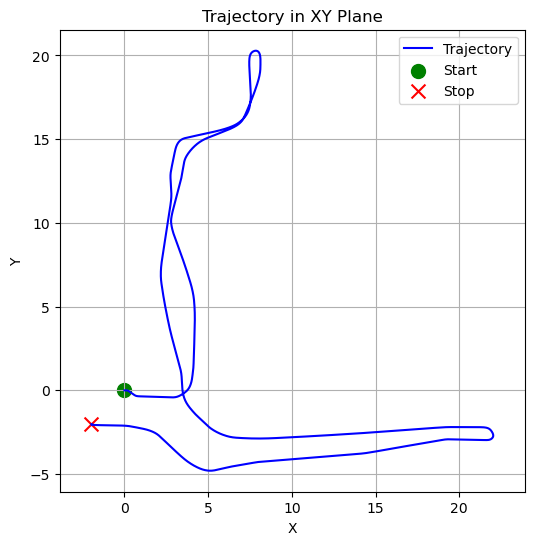

In [10]:

import matplotlib.pyplot as plt

def plot_trajectory(poses, additional_poses=None, title="Trajectory in XY Plane"):
    """
    Plots the trajectory of a sequence of poses in the XY plane.

    Parameters:
    - poses: A list or array of transformation matrices (4x4).
    - additional_poses: An optional list or array of transformation matrices (4x4) for the second trajectory to be plotted in orange.
    - title: Title for the plot (default: "Trajectory in XY Plane").
    """
    xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in poses])
    
    plt.figure(figsize=(6, 6))
    
    # Plot the primary trajectory
    plt.plot(xy_positions[:, 0], xy_positions[:, 1], label='Trajectory', color='blue')
    plt.scatter(xy_positions[0, 0], xy_positions[0, 1], color='green', label='Start', s=100, marker='o')
    plt.scatter(xy_positions[-1, 0], xy_positions[-1, 1], color='red', label='Stop', s=100, marker='x')

    if additional_poses is not None:
        additional_xy_positions = np.array([[pose[0, 3], pose[1, 3]] for pose in additional_poses])
        plt.plot(additional_xy_positions[:, 0], additional_xy_positions[:, 1], label='Additional Trajectory', color='orange')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    plt.axis('equal')  # Ensure equal scaling on both axes.
    plt.legend()
    plt.show()

plot_trajectory(encoder_poses)

In [11]:
def get_lidar_pc(lidar_raw_vals,  lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment):
    lidar_angles= np.linspace(lidar_angle_min, lidar_angle_max, int((lidar_angle_max - lidar_angle_min) / lidar_angle_increment) + 1)
    lidar_val_mask = np.where((lidar_raw_vals > lidar_range_min) & (lidar_raw_vals < lidar_range_max), True, False)
    lidar_raw_vals_masked = lidar_raw_vals[lidar_val_mask]
    lidar_angles_masked = lidar_angles[lidar_val_mask]
    lidar_x = lidar_raw_vals_masked * np.cos(lidar_angles_masked) 
    lidar_y = lidar_raw_vals_masked * np.sin(lidar_angles_masked)
    lidar_z = np.zeros(lidar_raw_vals_masked.shape[0])
    return np.column_stack((lidar_x,lidar_y,lidar_z))

In [24]:
import gtsam 
from gtsam import Pose3, Rot3, Point3

def matrix_to_pose3(T):
    R, p = ICP_stuff.get_R_and_P(T)
    return Pose3(Rot3(R), Point3(p))

poses = encoder_poses          # List of 4x4 absolute transformation matrices
# relative_poses = relative_poses  # List of 4x4 relative transformations (ICP-based)

# Define noise models
prior_noise = gtsam.noiseModel.Diagonal.Sigmas([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])  # Small uncertainty
odometry_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])  # Odometry uncertainty


In [50]:
import ICP_stuff
from tqdm import tqdm

prev_pose= T_0
accumulated_pose= T_0
trajectory= []
lidar_body_pose = ICP_stuff.get_pose(np.identity(3), np.array([0.13323,0,0.51435]))

factor_idx=1
fixed_interval=10

graph = gtsam.NonlinearFactorGraph()
init_guess= gtsam.Values()
poses= encoder_poses
for idx in tqdm(range(encoder_ts.shape[0]-1)):
    
    enc_ts_at_t = encoder_ts[idx]
    enc_ts_at_t1 = encoder_ts[idx+1]

    # LTDAR stuff at time t
    lidar_range_val_at_t = lidar_ranges[:, lidar_sync_map[enc_ts_at_t]]
    lidar_pc_at_t = get_lidar_pc(lidar_range_val_at_t, lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t = poses[idx] @ lidar_body_pose

    # LTDAR stuff at time t+1
    lidar_range_val_at_t1 = lidar_ranges[:, lidar_sync_map[enc_ts_at_t1]]  
    lidar_pc_at_t1 = get_lidar_pc(lidar_range_val_at_t1,lidar_range_min, lidar_range_max, lidar_angle_min, lidar_angle_max, lidar_angle_increment[0,0])
    pose_at_t1 = poses[idx+1] @ lidar_body_pose

    init_pose_for_ICP = np.linalg.inv(pose_at_t) @ pose_at_t1

    icp_estimated_pose = ICP_stuff.ICP(lidar_pc_at_t, lidar_pc_at_t1, init_pose_for_ICP, 2.5)

    if idx==0:
        graph.add(gtsam.PriorFactorPose3(idx, matrix_to_pose3(pose_at_t), prior_noise))
        init_guess.insert(idx,matrix_to_pose3(pose_at_t))
    else:
        graph.add(gtsam.BetweenFactorPose3(idx, idx+1, matrix_to_pose3(icp_estimated_pose), odometry_noise)) #add the next factor from ICP
        init_guess.insert(idx, matrix_to_pose3(pose_at_t))  #add the next guess from motion model


100%|██████████| 4955/4955 [01:03<00:00, 78.27it/s] 


In [51]:
# Step 3: Optimize the Graph
params = gtsam.LevenbergMarquardtParams()
params.setMaxIterations(1000)
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, init_guess, params)
result = optimizer.optimize()

RuntimeError: Attempting to at the key "4955", which does not exist in the Values.

In [49]:
optimized_poses = []

for i in range(len(poses)):  # Iterate over all pose indices
    optimized_pose = result.atPose3(i)  # Get optimized Pose3
    T = np.eye(4)  # Initialize 4x4 matrix

    # Extract rotation and translation from Pose3
    T[:3, :3] = optimized_pose.rotation().matrix()
    T[:3, 3] = optimized_pose.translation()

    optimized_poses.append(T)

# Now, optimized_poses is a list of 4x4 matrices
optimized_poses= np.array(optimized_poses)
plot_trajectory(encoder_poses , optimized_poses)

NameError: name 'result' is not defined